Installing packages:

In [1]:
%pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


Verify installation:

In [3]:
import sklearn

In [4]:
print(sklearn.__version__)

1.2.0


Importing packages:

In [5]:
import pandas as pd

In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt

In [8]:
import seaborn as sns

In [9]:
import nltk

In [31]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate # allows the computation of training scores

In [34]:
from sklearn.preprocessing import LabelEncoder

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [ ]:
from sklearn.pipeline import Pipeline

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

In [43]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
import sagemaker
import boto3

In [18]:
# is this needed?
sess = sagemaker.Session()
region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
s3_client

In [19]:
# check region
print(region)

us-east-2


Load data:

In [22]:
read_bucket = "twitter-sxsw"
file_name = "judge-1377884607_tweet_product_company.csv"

In [27]:
data_uri = f"s3://{read_bucket}/{file_name}"
data = pd.read_csv(data_uri, encoding='latin-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Clean data:

In [28]:
# rename lengthy column names
data.rename({'emotion_in_tweet_is_directed_at': 'object_of_sentiment',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)

In [29]:
# replace "I can't tell" in sentiment column with null
data.sentiment = data.sentiment.replace({"I can't tell": None})
# drop records with null value for sentiment
data.dropna(subset='sentiment', inplace=True)

In [30]:
# drop tweet that is missing tweet_text
data.dropna(subset='tweet_text', inplace=True)

In [32]:
data.head()

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Train test split:

In [33]:
seed = 23984

X_train, X_test, y_train, y_test = train_test_split(data['tweet_text'].copy(),
                                                    data['sentiment'].copy(),
                                                    test_size=0.2,
                                                    random_state=seed)

Label encode target:

In [40]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(y_train_encoded.shape)
print(y_test_encoded.shape)
print(pd.Series(y_train_encoded).value_counts(normalize=True))
print(pd.Series(y_test_encoded).value_counts(normalize=True))

dict(zip(range(len(le.classes_)), le.classes_))

(7148,)
(1788,)
1    0.602966
2    0.335478
0    0.061556
dtype: float64
1    0.602908
2    0.324385
0    0.072707
dtype: float64


{0: 'Negative emotion',
 1: 'No emotion toward brand or product',
 2: 'Positive emotion'}

Preprocess features:

In [44]:
# clean up (remove punctuation & change to lower case) tweets & remove english stopwords
twitter_stopwords = ['sxsw', 'mention', 'link', 'rt']

stopwords_list = stopwords.words('english') + twitter_stopwords

def clean_up(tweet):
    return ' '.join([word.strip(string.punctuation).lower() for word in tweet.split() if
                     word.strip(string.punctuation).lower() not in stopwords_list])

In [45]:
# stemming
from nltk.stem import PorterStemmer

def get_stems(tweet):
    '''Takes in a string of words and outputs a string of stemmed tokens.'''
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

# test
get_stems('''She wasn't doing a thing that I could see, except standing there leaning on the balcony railing, holding
the universe together.''')

"she wasn't do a thing that i could see, except stand there lean on the balconi railing, hold the univers together."

In [49]:
# get stemmed tokens for training data & test data
X_train_stems = X_train.apply(clean_up).apply(get_stems)
X_test_stems = X_test.apply(clean_up).apply(get_stems)

X_train_stems.head()

8932    z6 news good news code valid 4:00-7:59:59p 03/...
4997    realli cool shit googl work googl web font loo...
5673    miss google' vp search marissa mayer last week...
8147    yet ipad pop-up store flawless appl ipad 2 lau...
6519    calvin geek charli sheen goddess schmittast googl
Name: tweet_text, dtype: object

Try several different parameter settings for count vectorization:

In [50]:
count_options = [
    CountVectorizer(),
    CountVectorizer(ngram_range=(1,2)),
    CountVectorizer(ngram_range=(1,3)),
    CountVectorizer(min_df=0.01, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.99),
    CountVectorizer(ngram_range=(1, 3), min_df=0.01, max_df=0.99),
    CountVectorizer(max_features=200, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), max_features=200, max_df=0.99),
    CountVectorizer(ngram_range=(1,3), max_features=200, max_df=0.99),
    CountVectorizer(max_features=800, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), max_features=800, max_df=0.99),
    CountVectorizer(ngram_range=(1,3), max_features=800, max_df=0.99),
    CountVectorizer(max_features=3000, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), max_features=3000, max_df=0.99),
    CountVectorizer(ngram_range=(1,3), max_features=3000, max_df=0.99)
]

Test settings for count vectorization:

In [54]:
%%time

rf = RandomForestClassifier(random_state=seed)
nb = MultinomialNB()
svc = SVC(random_state=seed)

rf_scores = []
nb_scores = []
svc_scores = []

for count in count_options:
    # vectorize
    final_X_train = count.fit_transform(X_train_stems)
    
    # get cross validation scores:
    rf_score = np.mean(cross_val_score(rf, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    nb_score = np.mean(cross_val_score(nb, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    svc_score = np.mean(cross_val_score(svc, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    
    # store results for review:
    rf_scores.append(rf_score)
    nb_scores.append(nb_score)
    svc_scores.append(svc_score)

CPU times: user 11min 58s, sys: 658 ms, total: 11min 59s
Wall time: 12min 1s


In [55]:
best_vectorizer_rf = np.argmax(rf_scores)
best_vectorizer_nb = np.argmax(nb_scores)
best_vectorizer_svc = np.argmax(svc_scores)

count_rf = count_options[best_vectorizer_rf]
count_nb = count_options[best_vectorizer_nb]
count_svc = count_options[best_vectorizer_svc]

print(f'rf: {count_rf}')
print(f'nb: {count_nb}')
print(f'svc: {count_svc}')

rf: CountVectorizer(max_df=0.99, max_features=3000)
nb: CountVectorizer()
svc: CountVectorizer()


Examine baseline models:

In [61]:
rf_pipe = Pipeline(steps=[
    ('vec', count_rf),
    ('clf', rf)
])

baseline_rf_cv = cross_validate(rf_pipe, X_train_stems, y_train_encoded, scoring='accuracy', return_train_score=True)

In [62]:
nb_pipe = Pipeline(steps=[
    ('vec', count_nb),
    ('clf', nb)
])

baseline_nb_cv = cross_validate(nb_pipe, X_train_stems, y_train_encoded, scoring='accuracy', return_train_score=True)

In [63]:
svc_pipe = Pipeline(steps=[
    ('vec', count_svc),
    ('clf', svc)
])

baseline_svc_cv = cross_validate(svc_pipe, X_train_stems, y_train_encoded, scoring='accuracy', return_train_score=True)

Baseline Naive Bayes Results:

In [72]:
np.mean(baseline_nb_cv['test_score'])

0.6625598614122057

In [73]:
np.mean(baseline_nb_cv['train_score'])

0.8161373075677064

Naive bayes is overfit to the training data. However, there is little that can be done to tweak the naive bayes classification algorithm.

----

Hyperparameter tuning:

**Random Forest**

Baseline:

In [70]:
np.mean(baseline_rf_cv['test_score'])

0.6799081953735558

In [71]:
np.mean(baseline_rf_cv['train_score'])

0.9634862003100677

A random forest with default settings is extremely overfit.

Hyperparameter tuning approach (to reduce overfitting):

Preventing Individual Trees from Overfitting to the Data:
- Increase min_samples_leaf
- Decrease max_depth

Preventing the Forest as a Whole from Overfitting to the Data:
- Increase n_estimators
- Decrease max_samples (each tree trains on fewer samples from the full training dataset)
- Decrease max_features (at each split, only consider max_features)

In [83]:
rf_params = {'clf__min_samples_leaf': randint(1, 50),
             'clf__max_depth': randint(1, 500),
             'clf__n_estimators': randint(5, 300),
             'clf__max_samples': uniform(0.05, 1),
             'clf__max_features': [1, 200, 500, 3000], # 3000 is the num of features in rf count vec
             'clf__random_state': [seed]}

rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=10, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

rf_search.fit(X_train_stems, y_train_encoded)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec',
                                              CountVectorizer(max_df=0.99,
                                                              max_features=3000)),
                                             ('clf',
                                              RandomForestClassifier(random_state=23984))]),
                   param_distributions={'clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f07e6ba1a20>,
                                        'clf__max_features': [1, 200, 500,
                                                              3000],
                                        'clf__max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f07e6517af0>,
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f07e63a2620>,
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f07e63a1600>,
                                        'clf__random_state': [23984]},
                   random_state=23984, return_train_score=True,
                   scoring='accuracy')

In [84]:
rf_search.best_score_

0.6629811124817209

In [92]:
pd.DataFrame(rf_search.cv_results_).loc[:, ['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'] ]

,mean_fit_time,params,mean_train_score,mean_test_score
0,0.942099,"{'clf__max_depth': 40, 'clf__max_features': 50...",0.604854,0.604505
1,0.402122,"{'clf__max_depth': 61, 'clf__max_features': 1,...",0.602966,0.602966
2,7.210547,"{'clf__max_depth': 435, 'clf__max_features': 3...",0.656757,0.633741
3,0.737124,"{'clf__max_depth': 454, 'clf__max_features': 5...",0.628917,0.626188
4,4.895207,"{'clf__max_depth': 471, 'clf__max_features': 5...",0.767487,0.662981
5,1.583103,"{'clf__max_depth': 434, 'clf__max_features': 3...",0.638220,0.624368
6,2.424957,"{'clf__max_depth': 225, 'clf__max_features': 5...",0.651371,0.636959
7,2.556461,"{'clf__max_depth': 268, 'clf__max_features': 3...",0.666060,0.633881
8,0.350587,"{'clf__max_depth': 492, 'clf__max_features': 1...",0.602966,0.602966
9,0.270331,"{'clf__max_depth': 41, 'clf__max_features': 1,...",0.602966,0.602966


The models trained during the randomized search are no longer overfit, though they have poorer performance on the validation set than the baseline random forest.

Let's increase the number of iterations run in case we can find a better fit somewhere in the search space.

In [112]:
rf_params = {'clf__min_samples_leaf': randint(1, 50),
             'clf__max_depth': randint(1, 500),
             'clf__n_estimators': randint(5, 300),
             'clf__max_samples': uniform(0.05, 1),
             'clf__max_features': [1, 200, 500, 3000], # 3000 is the num of features in rf count vec
             'clf__random_state': [seed]}

rf_search2 = RandomizedSearchCV(rf_pipe, rf_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

rf_search2.fit(X_train_stems, y_train_encoded)

rf_search2.best_score_

0.6710949574130312

In [113]:
rf_search2.best_estimator_

Pipeline(steps=[('vec', CountVectorizer(max_df=0.99, max_features=3000)),
                ('clf',
                 RandomForestClassifier(max_depth=140, max_features=500,
                                        max_samples=0.9438972932554696,
                                        min_samples_leaf=3, n_estimators=222,
                                        random_state=23984))])

In [115]:
rf_search.cv_results_['mean_train_score'][rf_search.best_index_]

0.7674869958110945

Once again, the best performing model is overfit.

In [116]:
pd.DataFrame(rf_search2.cv_results_).loc[:, ['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'] ]

,mean_fit_time,params,mean_train_score,mean_test_score
0,0.773109,"{'clf__max_depth': 40, 'clf__max_features': 50...",0.604854,0.604505
1,0.380569,"{'clf__max_depth': 61, 'clf__max_features': 1,...",0.602966,0.602966
2,7.186812,"{'clf__max_depth': 435, 'clf__max_features': 3...",0.656757,0.633741
3,0.735887,"{'clf__max_depth': 454, 'clf__max_features': 5...",0.628917,0.626188
4,4.113162,"{'clf__max_depth': 471, 'clf__max_features': 5...",0.767487,0.662981
5,1.586588,"{'clf__max_depth': 434, 'clf__max_features': 3...",0.638220,0.624368
6,2.386804,"{'clf__max_depth': 225, 'clf__max_features': 5...",0.651371,0.636959
7,2.551681,"{'clf__max_depth': 268, 'clf__max_features': 3...",0.666060,0.633881
8,0.340288,"{'clf__max_depth': 492, 'clf__max_features': 1...",0.602966,0.602966
9,0.264008,"{'clf__max_depth': 41, 'clf__max_features': 1,...",0.602966,0.602966


It is difficult to detect patterns in the randomized search cv results format. Ideally, I want to reduce variance in the model until it is underfit, then re-introduce variance slowly to find the optimal point between underfitting and overfitting.

In [119]:
no_samples = [1, 3, 5, 10, 20, 30, 50]

train_scores = []
val_scores = []

for num in no_samples:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, min_samples_leaf=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

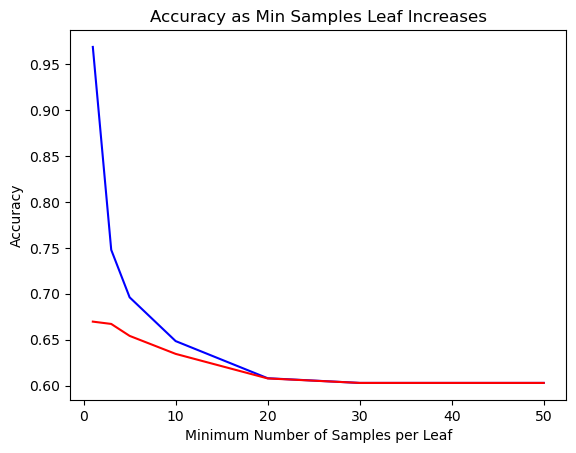

In [120]:
fig, ax = plt.subplots()

ax.set_title('Accuracy as Min Samples Leaf Increases')
plt.plot(no_samples, train_scores, label='train', c='b')
plt.plot(no_samples, val_scores, label='val', c='r')
ax.set_xlabel('Minimum Number of Samples per Leaf')
ax.set_ylabel('Accuracy');

Demanding that more samples are preserved per leaf results in a decrease in both training and validation accuracy. The model is no longer overfit to the training data when min_samples_leaf reaches a value of 20.

In [137]:
no_max_samples = np.linspace(0.05, 1, 9)

train_scores = []
val_scores = []

for num in no_max_samples:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

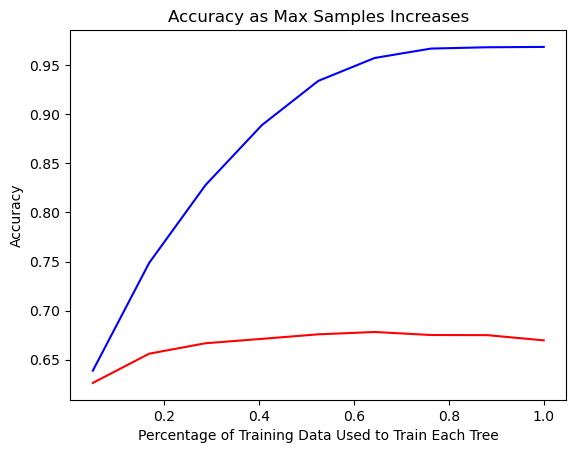

In [138]:
fig, ax = plt.subplots()

ax.set_title('Accuracy as Max Samples Increases')
plt.plot(no_max_samples, train_scores, label='train', c='b')
plt.plot(no_max_samples, val_scores, label='val', c='r')
ax.set_xlabel('Percentage of Training Data Used to Train Each Tree')
ax.set_ylabel('Accuracy');

In [139]:
print(f'Percentage of dataset used to train each tree: {no_max_samples[np.argmax(val_scores)]}')
print(f'Validation accuracy: {np.max(val_scores)}')

Percentage of dataset used to train each tree: 0.64375
Validation accuracy: 0.6782308776165343


Allowing individual trees to overfit has resulted in the best validation accuracy so far, despite also resulting in the forest as a whole overfitting. For this reason, I am going to focus on trying to reduce variance in the forest as a whole rather than in individual trees.

In [140]:
no_feats = np.linspace(0.01, 0.99, 20)

train_scores = []
val_scores = []

for num in no_feats:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=0.65, max_features=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

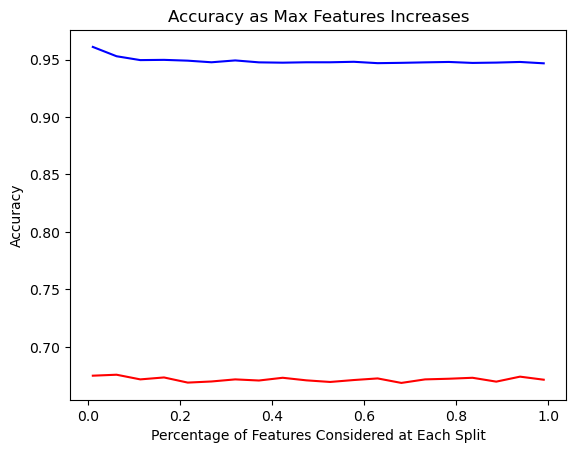

In [142]:
fig, ax = plt.subplots()

ax.set_title('Accuracy as Max Features Increases')
plt.plot(no_feats, train_scores, label='train', c='b')
plt.plot(no_feats, val_scores, label='val', c='r')
ax.set_xlabel('Percentage of Features Considered at Each Split')
ax.set_ylabel('Accuracy');

Varying the number of features considered at each split had little effect on the validation accuracy.

As a last experiment, increase the number of estimators.

In [143]:
no_estimators = [100, 200, 300, 400, 500]

train_scores = []
val_scores = []

for num in no_estimators:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=0.65, n_estimators=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

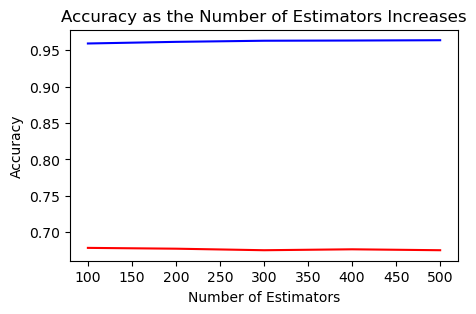

In [149]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.set_title('Accuracy as the Number of Estimators Increases')
plt.plot(no_estimators, train_scores, label='train', c='b')
plt.plot(no_estimators, val_scores, label='val', c='r')
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy');

In [150]:
no_estimators = [10, 20, 50, 80, 100]

train_scores = []
val_scores = []

for num in no_estimators:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=0.65, n_estimators=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

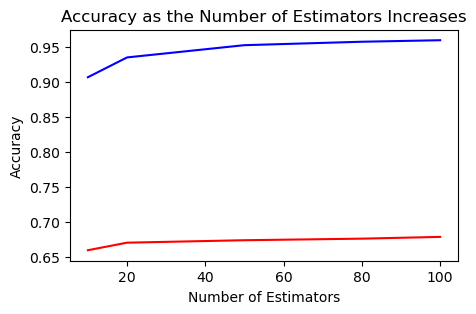

In [151]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.set_title('Accuracy as the Number of Estimators Increases')
plt.plot(no_estimators, train_scores, label='train', c='b')
plt.plot(no_estimators, val_scores, label='val', c='r')
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy');

The default number of estimators performs best.

Best Random Forest Classifier so Far:

In [155]:
best_rf = RandomForestClassifier(random_state=seed, max_samples=0.65)

best_rf_pipe = Pipeline(steps=[
    ('vec', count_rf),
    ('clf', best_rf)
])

np.mean(cross_val_score(best_rf_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.6786498120432549

---

Hyperparameter tuning:

**Support Vector Machine**

Baseline:

In [75]:
np.mean(baseline_svc_cv['test_score'])

0.6843847964491772

In [76]:
np.mean(baseline_svc_cv['train_score'])

0.8732161977211753

A support vector machine with default settings is overfit.

Hyperparameter tuning approach (to reduce overfitting):

Decreasing Overfitting:
- Decrease gamma (more widespread influence of each training example produces a smoother model)
- Decrease C (inverse regularization parameter; smaller values of C result in a larger margin for hyperplane at the cost of possibly mis-classifying some training examples)

Other Parameters:
- It is possible to change the kernel from the default rbf. I don't expect a linear kernel to perform well, but it is worth trying a poly kernel with varying degrees.

In order to decrease gamma, I need to know it's default value. The documentation states that gamma scales automatically to 1 / (n_features\*X.var()) as the default setting for a support vector classifier.

In [106]:
# figure out default value of gamma

svc_train = count_svc.fit_transform(X_train_stems).todense() # use all training data; close enough

1 / (svc_train.shape[1] * np.var(svc_train))

0.09348563491113145

In [107]:
svc_params = {'clf__gamma': uniform(10**(-9), 1),
              'clf__C': uniform(0.001, 0.09)}

svc_search = RandomizedSearchCV(svc_pipe, svc_params, n_iter=10, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search.fit(X_train_stems, y_train_encoded)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                             ('clf', SVC(random_state=23984))]),
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f07e4cbaf80>,
                                        'clf__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f07e4cbb850>},
                   random_state=23984, return_train_score=True,
                   scoring='accuracy')

In [108]:
svc_search.best_score_

0.6033854881443436

In [109]:
pd.DataFrame(svc_search.cv_results_).loc[:, ['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'] ]

,mean_fit_time,params,mean_train_score,mean_test_score
0,4.058472,"{'clf__C': 0.08596791929384898, 'clf__gamma': ...",0.603595,0.603385
1,3.109041,"{'clf__C': 0.07702712680333602, 'clf__gamma': ...",0.602966,0.602966
2,3.968256,"{'clf__C': 0.09084978885614454, 'clf__gamma': ...",0.603595,0.603385
3,3.890370,"{'clf__C': 0.03942784025333891, 'clf__gamma': ...",0.602966,0.602966
4,3.886014,"{'clf__C': 0.04826374781705454, 'clf__gamma': ...",0.602966,0.602966
5,3.884237,"{'clf__C': 0.02662083116622858, 'clf__gamma': ...",0.602966,0.602966
6,3.798048,"{'clf__C': 0.013445677287554265, 'clf__gamma':...",0.602966,0.602966
7,4.170705,"{'clf__C': 0.07760262508270892, 'clf__gamma': ...",0.602966,0.602966
8,3.855991,"{'clf__C': 0.03060115753549196, 'clf__gamma': ...",0.602966,0.602966
9,3.880646,"{'clf__C': 0.07382564431040683, 'clf__gamma': ...",0.603735,0.603385


As with the first search for the optimal hyperparameters for the random forest algorithm, the performance of the models tested on the validation data is sub-optimal compared to the baseline, but these models are not overfit, whereas the baseline model is overfit.

Try increasing the number of iterations of the random search.

In [158]:
svc_params = {'clf__C': uniform(10**(-9), 1),
              'clf__gamma': uniform(0.001, 0.09)}

svc_search2 = RandomizedSearchCV(svc_pipe, svc_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search2.fit(X_train_stems, y_train_encoded)

svc_search2.best_score_

0.6715148314179444

The best model obtained so far from random search is still slightly inferior to the baseline model.

Let's experiment with a polynomial kernel for the SVM.

In [163]:
svc_params = {'clf__kernel': ['poly'],
              'clf__degree': randint(1, 5)}

svc_search3 = RandomizedSearchCV(svc_pipe, svc_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search3.fit(X_train_stems, y_train_encoded)

svc_search3.best_score_

0.6740320788437645

In [164]:
svc_search.best_estimator_

Pipeline(steps=[('vec', CountVectorizer()),
                ('clf', SVC(degree=1, kernel='poly', random_state=23984))])

This score is getting close to that of the baseline model. I will try adjusting gamma and C with the settings of the best polynomial kernel estimator.

In [165]:
svc_params = {'clf__C': uniform(10**(-9), 1),
              'clf__gamma': uniform(0.001, 0.09),
              'clf__kernel': ['poly'],
              'clf__degree': [1]}

svc_search4 = RandomizedSearchCV(svc_pipe, svc_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search4.fit(X_train_stems, y_train_encoded)

svc_search4.best_score_

0.6653580104149894

----

Hyperparameter tuning:

**XGBoost**

The best performing model so far is a support vector classifier with default settings.

One last option we can try is the popular and high-performing algorithm XG Boost.

In [169]:
%pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 1.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [170]:
from xgboost import XGBClassifier

Because XGBoost is based on the concept of a random forest, I will use the count vectorization that worked best with the baseline random forest model.

In [172]:
xgb = XGBClassifier(random_state=seed)

xgb_pipe = Pipeline(steps=[
    ('vec', count_rf),
    ('clf', xgb)
])

cv_results = cross_validate(xgb_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                            return_train_score=True)

In [173]:
np.mean(cv_results['train_score'])

0.811485679503455

In [174]:
np.mean(cv_results['test_score'])

0.6815875207103588

The baseline accuracy score for an XGBoost classifier with default hyperparameters is ~68.2%.

In [190]:
xgb_params = {'clf__n_estimators': randint(20, 120),
              'clf__eta': uniform(0.1, 0.5),
              'clf__gamma': uniform(0, 10),
              'clf__max_depth': randint(4, 10),
              'clf__reg_lambda': uniform(0, 1),
              'clf__max_leaves': [0, 500, 1000]}

xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=50, scoring='accuracy', cv=3, random_state=seed,
                                return_train_score=True)

xgb_search.fit(X_train_stems, y_train_encoded)

xgb_search.best_score_

0.6845250532065513

In [191]:
xgb_search.best_estimator_

Pipeline(steps=[('vec', CountVectorizer(max_df=0.99, max_features=3000)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.586848074852997,
                               eval_metric=None, feature_types=None,
                               gamma=0.8639733186829135, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=0, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=97, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [193]:
xgb_search.best_params_

{'clf__eta': 0.586848074852997,
 'clf__gamma': 0.8639733186829135,
 'clf__max_depth': 4,
 'clf__max_leaves': 0,
 'clf__n_estimators': 97,
 'clf__reg_lambda': 0.028973738988273823}

97 boosting rounds is expensive. But it did improve validation accuracy by 0.3%.

In [194]:
xgb_params = {'clf__n_estimators': randint(80, 100),
              'clf__eta': uniform(0.5, 0.7),
              'clf__gamma': uniform(0.75, 0.97),
              'clf__max_depth': randint(2, 6),
              'clf__reg_lambda': uniform(0.01, 0.05)}

xgb_search2 = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=50, scoring='accuracy', cv=3, random_state=seed,
                                return_train_score=True)

xgb_search2.fit(X_train_stems, y_train_encoded)

xgb_search2.best_score_

0.6836864209458287

In [195]:
xgb_search2.best_params_

{'clf__eta': 0.797611698096264,
 'clf__gamma': 0.8580053225064586,
 'clf__max_depth': 4,
 'clf__n_estimators': 81,
 'clf__reg_lambda': 0.021308051442514978}

The configuration of the XGBoost classifier from the first randomized search is the best model so far.

----

Evaluate on the hold-out test set: